In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
from fibonacci import generate_vertices
from commutators import test_angular_momentum_comutator, fourier_vector, calc_r
from lattice_actions import calc_mean_distance

In [16]:
N = np.array([2**i for i in range(3,9)])
Lattices = [generate_vertices(i) for i in N]
mean_distances= []
rs = []
k = np.array([0,0,0,0])
a = 1
n = 1
i,j = 0, 0
for vertex in Lattices:
    vec = fourier_vector(vertex, a, k)
    comm = test_angular_momentum_comutator(vertex, a, n=n, i=i,j=j)
    rs.append(calc_r(comm, vec=vec))
    mean_distances.append(calc_mean_distance(vertex))

\begin{equation*}
    z = \big([L_a,U_{il}] - (t_a)_{ji} U_{il})\cdot v(k)
\end{equation*}

\begin{equation*}
    r = \frac{1}{N}\sum_i |z_i|
\end{equation*}

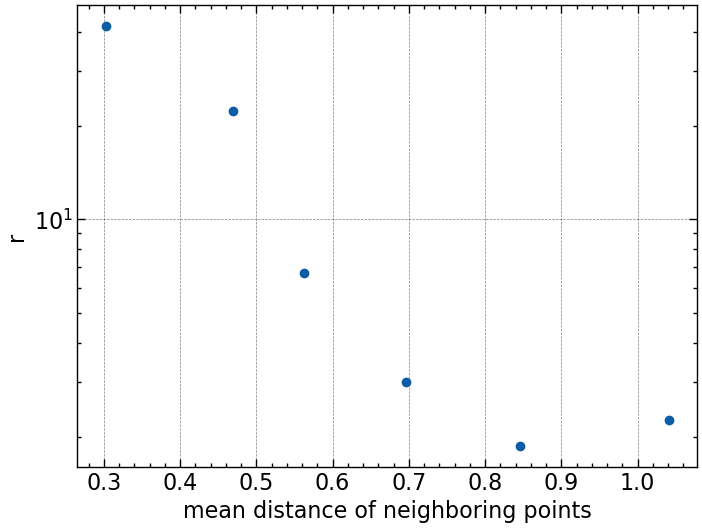

In [17]:
plt.plot(mean_distances, rs, "o")
plt.xlabel("mean distance of neighboring points")
plt.ylabel("r")
plt.yscale("log")
plt.show()

In [18]:
figsize = (8,6)

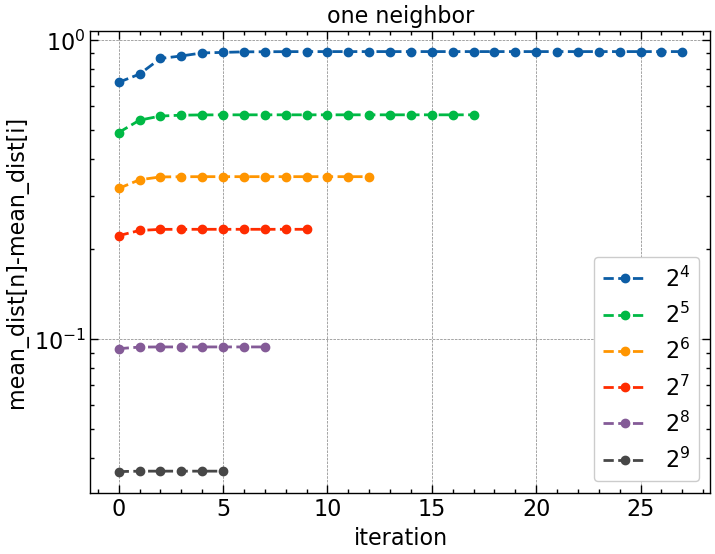

In [19]:
from lattice_optimisation import lattice_optimizer
from fibonacci import generate_vertices_angles

N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=1)

    plt.plot(arr,"o--", label=rf"$2^{exp}$")


plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("one neighbor")
plt.yscale("log")
plt.show()

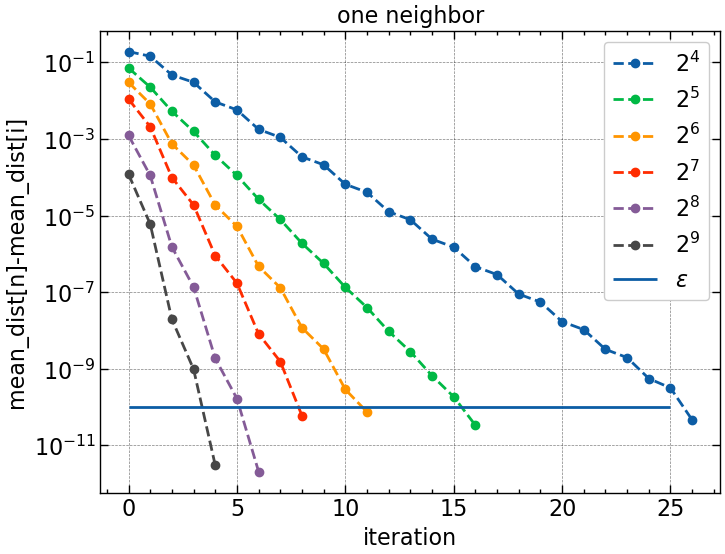

In [20]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=1)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("one neighbor")
plt.yscale("log")
plt.show()

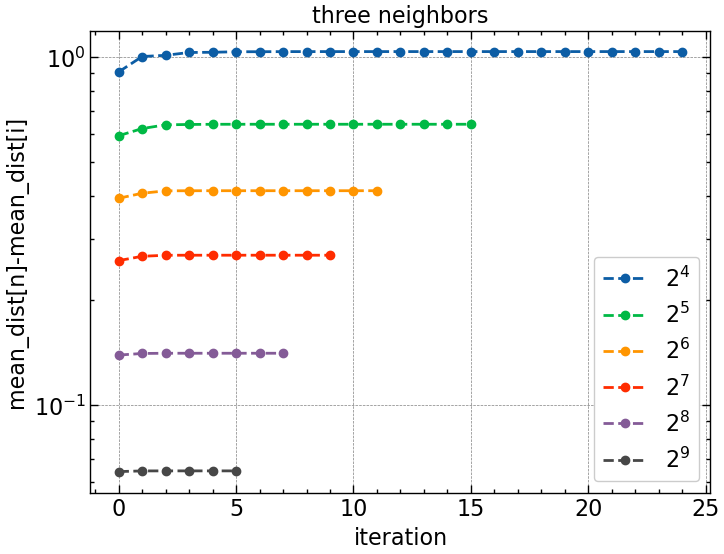

In [21]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=3)
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("three neighbors")
plt.yscale("log")
plt.show()

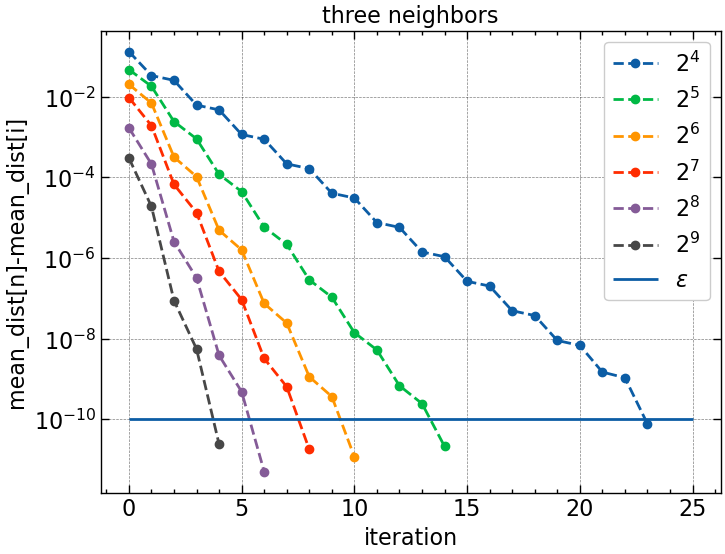

In [22]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=3)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("three neighbors")
plt.yscale("log")
plt.show()

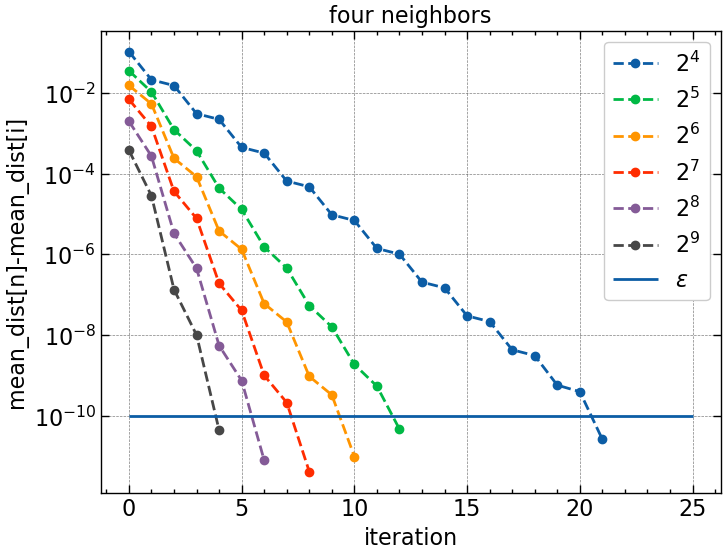

In [23]:
N = np.array([i for i in range(4,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=4)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("four neighbors")
plt.yscale("log")
plt.show()

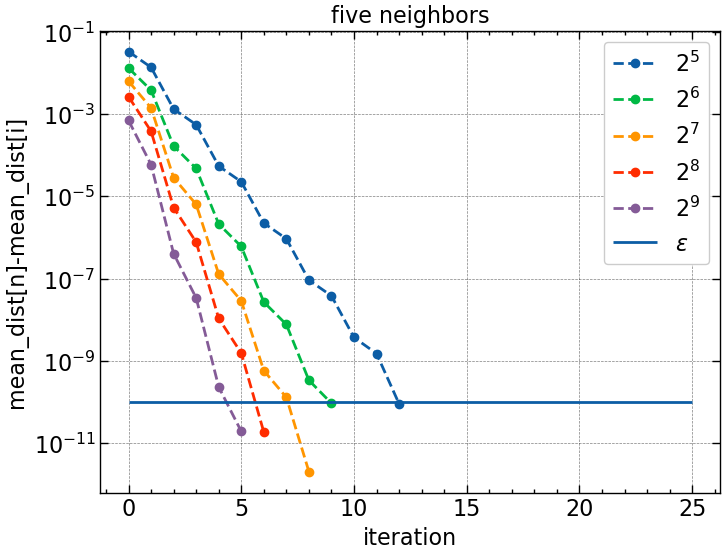

In [24]:
N = np.array([i for i in range(5,10)])
eps = 1e-10
plt.figure(figsize=figsize)
for exp in N:
    angles = generate_vertices_angles(2**exp)
    _,mean,arr = lattice_optimizer(angles, eps=eps, neighbors=5)
    arr = (mean-arr)[:-1]
    plt.plot(arr,"o--", label=rf"$2^{exp}$")

plt.hlines(eps, 0,25, label=rf"$\epsilon$")
plt.xlabel("iteration")
plt.ylabel("mean_dist[n]-mean_dist[i]")
plt.legend(loc="best")
plt.title("five neighbors")
plt.yscale("log")
plt.show()